## Time Series Prediction Model

### Data Preparation

#### Prepare ts_mta_hourly data

In [5]:
import pandas as pd

chunk_size = 100000
aggregated_chunks = []

for chunk in pd.read_csv('MTA_hourly_rides.csv', chunksize=chunk_size, low_memory=False):
    chunk_agg = chunk.groupby('time_id').agg({
        'ridership': 'sum',
        'transfers': 'sum'
    }).reset_index()
    
    aggregated_chunks.append(chunk_agg)

mta_rides_agg = pd.concat(aggregated_chunks, ignore_index=True)

final_aggregation = mta_rides_agg.groupby('time_id').agg({
    'ridership': 'sum',
    'transfers': 'sum'
}).reset_index()

print(final_aggregation.head())

         time_id  ridership  transfers
0  2022-03-01-00      15493        396
1  2022-03-01-01       5289        111
2  2022-03-01-02       3534         96
3  2022-03-01-03       4446        182
4  2022-03-01-04      15484        910


In [6]:
print(final_aggregation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18263 entries, 0 to 18262
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   time_id    18263 non-null  object
 1   ridership  18263 non-null  int64 
 2   transfers  18263 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.2+ KB
None


In [9]:
# final_aggregation.to_csv('ts_mta_hourly_rides.csv', index=False)

#### Combine Data

In [13]:
import pandas as pd

mta_rides_agg = pd.read_csv('ts_mta_hourly_rides.csv')
bike_rides = pd.read_csv('ts_bike_rides_hourly.csv')
weather = pd.read_csv('ts_weather.csv')

/var/folders/bv/d_q6w5r536b_pgv6bn4vgh500000gn/T/ipykernel_46490/3969044794.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_rides = pd.read_csv('ts_bike_rides_hourly.csv')


In [14]:
mta_rides_agg['time_id'] = pd.to_datetime(mta_rides_agg['time_id'], format='%Y-%m-%d-%H')
bike_rides['time_id'] = pd.to_datetime(bike_rides['time_id'], format='%Y-%m-%d-%H')
weather['time_id'] = pd.to_datetime(weather['time_id'], format='%Y-%m-%d-%H')

In [15]:
print("MTA Rides Time Range:")
print(mta_rides_agg['time_id'].min(), "to", mta_rides_agg['time_id'].max())

print("\nBike Rides Time Range:")
print(bike_rides['time_id'].min(), "to", bike_rides['time_id'].max())

print("\nWeather Time Range:")
print(weather['time_id'].min(), "to", weather['time_id'].max())

MTA Rides Time Range:
2022-03-01 00:00:00 to 2024-03-31 00:00:00

Bike Rides Time Range:
2022-03-01 00:00:00 to 2024-03-30 23:00:00

Weather Time Range:
2020-07-01 00:00:00 to 2024-06-30 23:00:00


In [16]:
# Filter time range (weather)
filtered_weather = weather[(weather['time_id'] >= '2022-03-01 00:00:00') & 
                           (weather['time_id'] <= '2024-03-30 23:00:00')]

In [17]:
# Aggregate the Bike Rides dataset
bike_rides_agg = bike_rides.groupby('time_id').agg({
    'total_rides': 'sum'
}).reset_index()

In [18]:
# Check for duplicates in MTA Rides and Weather datasets
print("Duplicates in MTA Rides:", mta_rides_agg.duplicated(subset=['time_id']).sum())
print("Duplicates in Weather:", filtered_weather.duplicated(subset=['time_id']).sum())

Duplicates in MTA Rides: 0
Duplicates in Weather: 0


In [19]:
# Merge MTA Rides and Aggregated Bike Rides
combined_data = pd.merge(mta_rides_agg, bike_rides_agg, on='time_id', how='inner')

# Merge the result with Weather data
final_data = pd.merge(combined_data, filtered_weather, on='time_id', how='inner')

In [20]:
# Check the final dataset
print("Final Combined Dataset (Corrected):")
print(final_data.head())
print("\nShape of Final Dataset (Corrected):", final_data.shape)

Final Combined Dataset (Corrected):
              time_id  ridership  transfers  total_rides  temperature  \
0 2022-03-01 00:00:00      15493        396          315         32.0   
1 2022-03-01 01:00:00       5289        111          135         32.0   
2 2022-03-01 02:00:00       3534         96          106         32.0   
3 2022-03-01 03:00:00       4446        182           98         33.0   
4 2022-03-01 04:00:00      15484        910          155         33.0   

   wind_speed  precipitation  
0         5.0            0.0  
1         0.0            0.0  
2         3.0            0.0  
3         3.0            0.0  
4         4.0            0.0  

Shape of Final Dataset (Corrected): (18261, 7)


In [21]:
final_data.to_csv('final_combined_time_series.csv', index=False)

#### EDA

In [162]:
import pandas as pd

file_path = "final_combined_time_series.csv"
final_data = pd.read_csv(file_path, parse_dates=True, index_col=0)

print(final_data.info())
print(final_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18261 entries, 2022-03-01 00:00:00 to 2024-03-30 23:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ridership      18261 non-null  int64  
 1   transfers      18261 non-null  int64  
 2   total_rides    18261 non-null  int64  
 3   temperature    18259 non-null  float64
 4   wind_speed     18232 non-null  float64
 5   precipitation  18259 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 998.6 KB
None
                     ridership  transfers  total_rides  temperature  \
time_id                                                               
2022-03-01 00:00:00      15493        396          315         32.0   
2022-03-01 01:00:00       5289        111          135         32.0   
2022-03-01 02:00:00       3534         96          106         32.0   
2022-03-01 03:00:00       4446        182           98         33.0   
2022-03-01 04:00:00   

In [163]:
final_data.index = pd.to_datetime(final_data.index)

In [164]:
final_data.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data.dropna(inplace=True)

In [165]:
final_data

,ridership,transfers,total_rides,temperature,wind_speed,precipitation
time_id,,,,,,
2022-03-01 00:00:00,15493,396,315,32.0,5.0,0.0000
2022-03-01 01:00:00,5289,111,135,32.0,0.0,0.0000
2022-03-01 02:00:00,3534,96,106,32.0,3.0,0.0000
2022-03-01 03:00:00,4446,182,98,33.0,3.0,0.0000
2022-03-01 04:00:00,15484,910,155,33.0,4.0,0.0000
...,...,...,...,...,...,...
2024-03-30 19:00:00,159429,4305,5387,59.0,5.0,0.0000
2024-03-30 20:00:00,126484,3246,2780,53.0,5.0,0.0001
2024-03-30 21:00:00,97091,2238,2134,51.0,5.0,0.0100


#### Model Training - Liner Regression

In [187]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [188]:
train = final_data.loc[:'2024-01-01']
test = final_data.loc['2024-01-01':'2024-03-29']

In [189]:
def create_features(data, lag=1):
    """Creates lagged features for the ridership time series."""
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'ridership_lag_{i}'] = df['ridership'].shift(i)
    df.dropna(inplace=True)
    return df

In [190]:
lag = 1
train_prepared = create_features(train, lag=lag)
test_prepared = create_features(test, lag=lag)


X_train = train_prepared.drop(columns=['ridership'])
y_train = train_prepared['ridership']
X_test = test_prepared.drop(columns=['ridership'])
y_test = test_prepared['ridership']

model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [191]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 662122733.4892709
R-squared: 0.9388390337712635


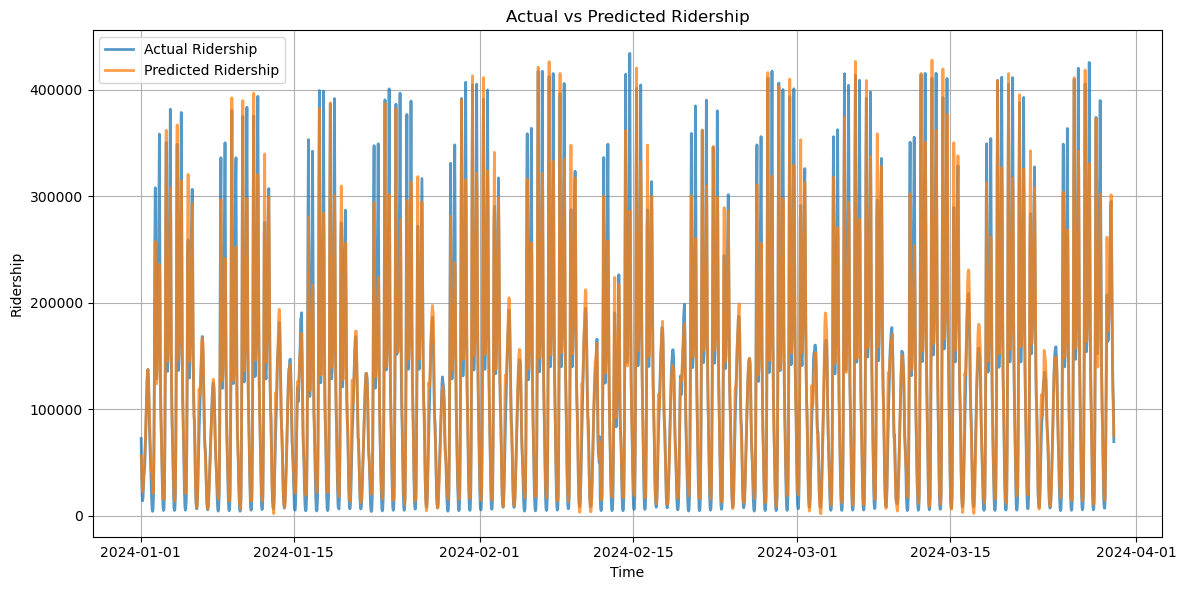

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Ridership", alpha=0.75, linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted Ridership", alpha=0.75, linewidth=2)
plt.title("Actual vs Predicted Ridership")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

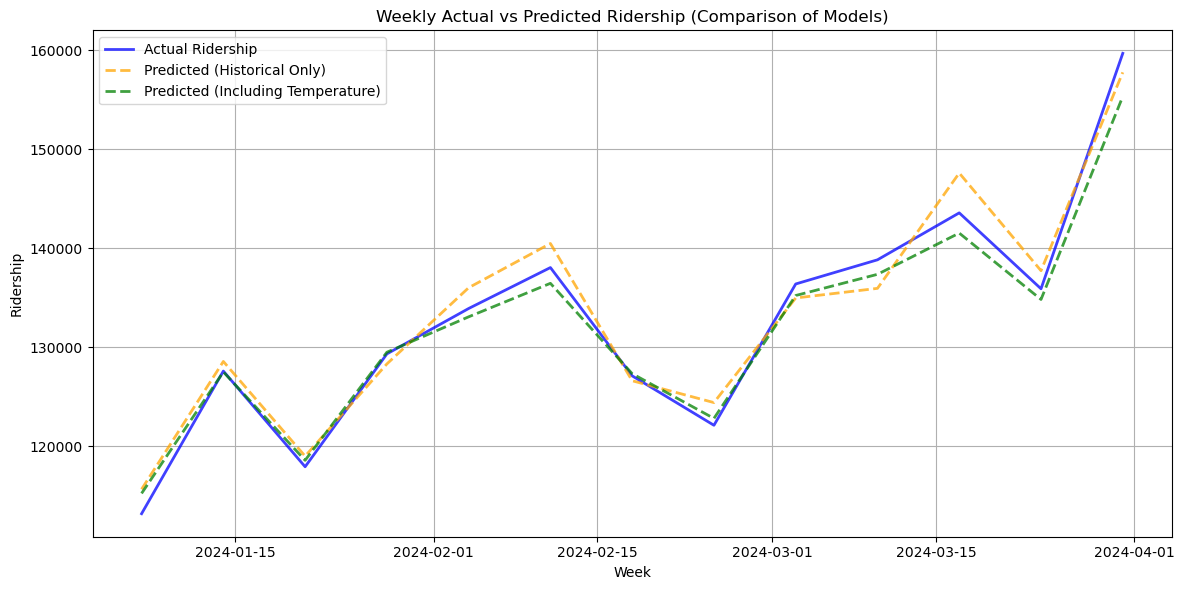

In [212]:
plt.figure(figsize=(12, 6))

plt.plot(results_weekly.index, results_weekly['Actual'], label="Actual Ridership", alpha=0.75, linewidth=2, color='blue')
plt.plot(results_weekly.index, results_weekly['Predicted'], label="Predicted (Historical Only)", alpha=0.75, linewidth=2, color='orange', linestyle='--')
plt.plot(results_hist_weekly.index, results_hist_weekly['Predicted_Historical_Only'], label="Predicted (Including Temperature)", alpha=0.75, linewidth=2, color='green', linestyle='--')

plt.title("Weekly Actual vs Predicted Ridership (Comparison of Models)")
plt.xlabel("Week")
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [199]:
X_train_hist = train_prepared.drop(columns=['ridership', 'temperature'])
y_train_hist = train_prepared['ridership']
X_test_hist = test_prepared.drop(columns=['ridership', 'temperature'])
y_test_hist = test_prepared['ridership']

model_hist = make_pipeline(StandardScaler(), LinearRegression())

model_hist.fit(X_train_hist, y_train_hist)

y_pred_hist = model_hist.predict(X_test_hist)

mse_hist = mean_squared_error(y_test_hist, y_pred_hist)
r2_hist = r2_score(y_test_hist, y_pred_hist)

print(f"Historical Ridership Only Model - Mean Squared Error: {mse_hist}")
print(f"Historical Ridership Only Model - R-squared: {r2_hist}")

Historical Ridership Only Model - Mean Squared Error: 2730867771.967159
Historical Ridership Only Model - R-squared: 0.7474813351482577


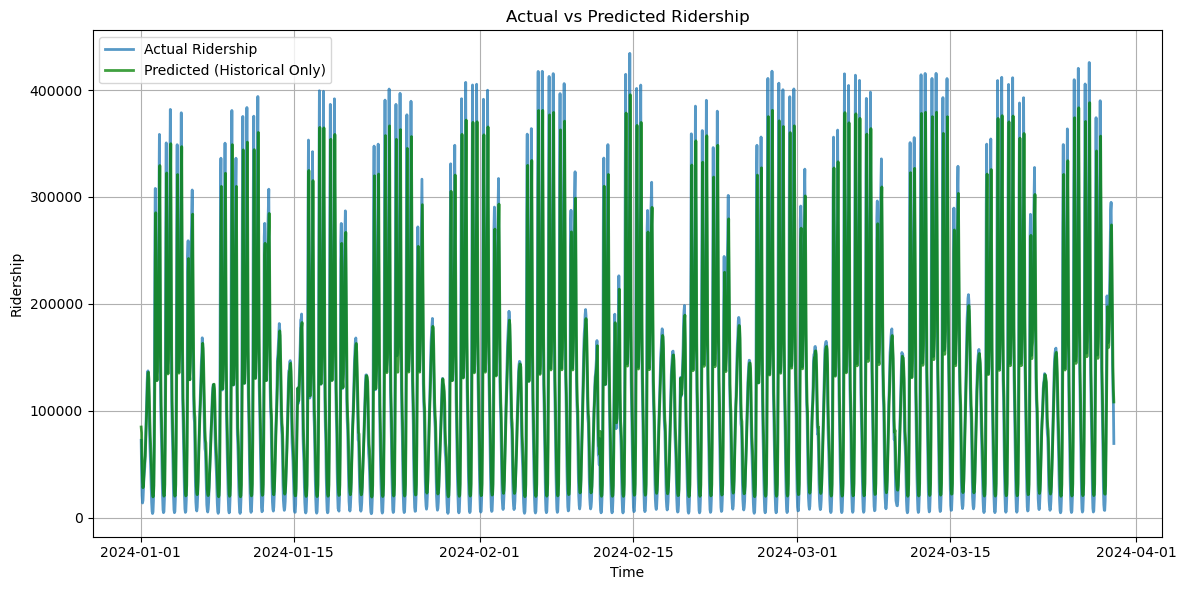

In [206]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Ridership", alpha=0.75, linewidth=2)
plt.plot(y_test_hist.index, y_pred_hist, label="Predicted (Historical Only)", color='green', alpha=0.75, linewidth=2)
plt.title("Actual vs Predicted Ridership")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [167]:
import pandas as pd

train = final_data.loc[:'2024-01-01']
test = final_data.loc['2024-01-01':'2024-03-29']

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (16101, 6)
Test Shape: (2131, 6)


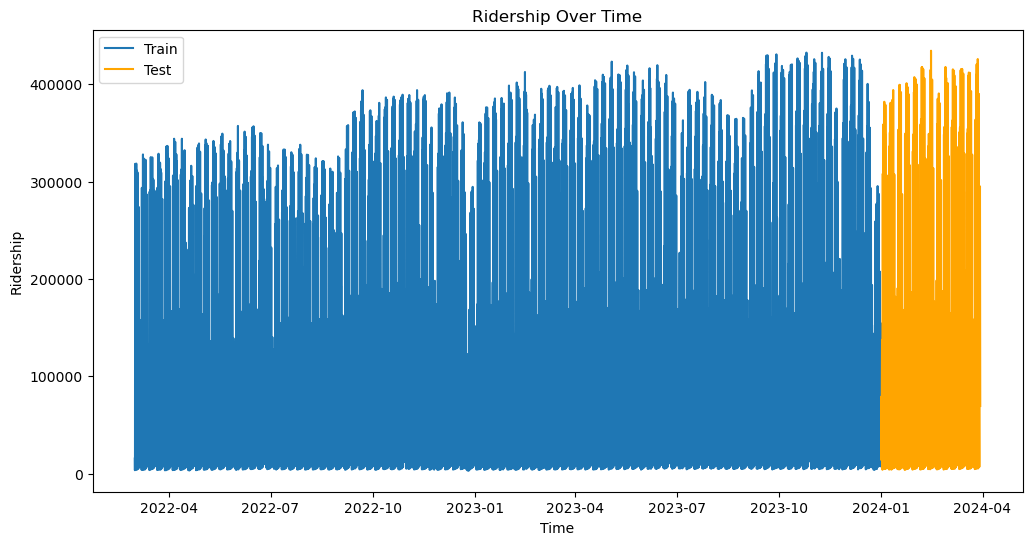

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['ridership'], label='Train')
plt.plot(test.index, test['ridership'], label='Test', color='orange')
plt.title('Ridership Over Time')
plt.xlabel('Time')
plt.ylabel('Ridership')
plt.legend()
plt.show()